In [4]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt

def parse_data(paths):
    result_dict = {}
    dicts = []
    for path in paths:
        with open(path, 'rb') as f:
            dicts.append(pickle.load(f))
    for dict in dicts:
        for key in dict:
            next_entrance = dict[key].reshape([1, -1])
            if key in result_dict:
                result_dict[key] = np.append(result_dict[key], next_entrance, axis=0)
            else:
                result_dict[key] = next_entrance
    return result_dict

def plot_experiment_data(timesteps, experiments, names, plot_name, path=None):
    # create figure and axis objects
    fig, ax = plt.subplots()

    # loop over experiments
    for i, experiment in enumerate(experiments):
        # calculate mean and standard deviation of each time step for this experiment
        mean_data = np.mean(experiment, axis=0)
        std_data = np.std(experiment, axis=0) * 1 / np.sqrt(experiment.shape[0]) 

        # plot mean data as a line and shade area between ±1 standard deviation
        ax.plot(timesteps[i], mean_data, '-o', markersize=5, label=names[i])
        ax.fill_between(timesteps[i], mean_data-std_data, mean_data+std_data, alpha=0.3)

    # add labels, title, and legend to the plot
    ax.set_xlabel('Number Sampled Trajectories')
    ax.set_ylabel('Success Rate')
    ax.set_title(plot_name)
    ax.legend(loc = 'upper left')

    if path is not None:
        # create directory if it doesn't exist
        os.makedirs(path, exist_ok=True)
        # save the plot
        plt.savefig(os.path.join(path, plot_name + '.png'))

    # display the plot
    plt.show()

def file_crawler(path, substrings, exclude=[]):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            file_path = os.path.join(root, name)
            if all(s in file_path for s in substrings) and not any(e in file_path for e in exclude):
                result.append(file_path)
    print(f'for path: {path}: {len(result)}')
    return result

def make_plot(paths, includes, excludes, names, plot_name, save_path = None):
    abs_file_path_list = []
    
    for i in range(len(paths)):
        abs_file_path_list.append(file_crawler(path=paths[i], substrings=includes[i], exclude=excludes[i]))
    dicts = []
    
    for result in abs_file_path_list:
        dicts.append(parse_data(paths=result))

    plot_experiment_data(
        timesteps=[result_dict['step'][0] for result_dict in dicts], 
        experiments=[result_dict['success_rate'] for result_dict in dicts],
        names=names,
        plot_name=plot_name,
        path=save_path
        )
    
def make_stepsize_data(path, include, exclude, step_size):
    abs_file_path_list = []
    abs_file_path_list.append(file_crawler(path=path, substrings=include, exclude=exclude))
    print(len(abs_file_path_list[0]))
    for path in abs_file_path_list[0]:
        with open(path, 'rb') as f:
            dict = pickle.load(f)
            mask = dict['step'] % step_size == 0
            new_dict = {}
            for key in dict:
                new_dict[key] = dict[key][mask]
            new_path = path + f'_stepsize_{step_size}'
            with open(new_path, 'wb') as handle:
                pickle.dump(new_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-07'
include = ['reach', 'demonstrations_4', 'TQC', 'learner']
exclude = []
step_size = 10
make_stepsize_data(path=bl_path, include=include, exclude=exclude, step_size=step_size)

In [ ]:
from active_critic.analyze_stats.push_TQC_PPO_GAIL_5000_10000 import run_exp
run_exp()

In [ ]:
from active_critic.analyze_stats.push_10_GAIL_TQC_PPO import run_exp
run_exp()

In [ ]:
ac_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-16'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-17'

include_AC = ['pickplace', 'stats', '30', 'plan']
exclude_AC = [' id: 2', 'optimize']

include_AC_plan = ['pickplace', 'stats', '30', 'actor']
exclude_AC_plan = [' id: 2', 'optimize']

include_AC_actions = ['pickplace', 'stats', '30', 'actions']
exclude_AC_actions = [' id: 3', 'optimize']

include_bl_RPPO = ['PPO', 'learner']
exclude_AC_actions = ['RPPO', 'id_1']

save_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-14'

make_plot(
    paths=[ac_path, bl_path], 
    includes=[include_AC, include_bl_RPPO], 
    excludes=[exclude_AC, exclude_AC_actions],
    names=['AC Plan', 'RPPO', 'AC Actions', 'TQC + GAIL'],
    plot_name='Reach Environment',
    save_path = None
    )

In [ ]:
ac_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-15'

include_AC = ['pickplace', 'stats', '50000', 'optimize']
exclude_AC = []

include_AC_actor = ['pickplace', 'stats', '50000']
exclude_AC_actor = ['optimize']

save_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-14'

make_plot(
    paths=[ac_path, ac_path], 
    includes=[include_AC, include_AC_actor], 
    excludes=[exclude_AC, exclude_AC_actor],
    names=['AC Imitation Only', 'AC Reinforcement', 'PPO + GAIL', 'BC + RPPO', 'TQC + GAIL'],
    plot_name='Reach Environment',
    save_path = None
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-07'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-07'

include_ac_reach_4_im = ['reach', 'stats', 'True', 'demonstrations: 4']
exclude_ac_imitation = ['optimized']

include_ac_reach_4_ref = ['reach', 'stats', 'False', 'demonstrations: 4']
exclude_ac_imitation = ['optimized']

include_PPO_reach_4 = ['reach', 'demonstrations_4', 'PPO', 'learner_stats_gail']
exclude_bl_PPO = ['RPPO']

include_RPPO_reach_4 = ['reach', 'demonstrations_4', 'RPPO', 'learner_stats_rec_PPO_stepsize_10']
exclude_bl_RPPO = []

include_TQC_reach_4 = ['reach', 'demonstrations_4', 'TQC', 'learner_stats_gail_stepsize_10']
exclude_bl_RPPO = []

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/reach 4'

make_plot(
    paths=[AC_path, AC_path, bl_path, bl_path, bl_path], 
    includes=[include_ac_reach_4_im, include_ac_reach_4_ref, include_PPO_reach_4, include_RPPO_reach_4, include_TQC_reach_4], 
    excludes=[exclude_ac_imitation, exclude_ac_imitation, exclude_bl_PPO, exclude_bl_RPPO, exclude_bl_RPPO],
    names=['AC Imitation Only', 'AC Reinforcement', 'PPO + GAIL', 'BC + RPPO', 'TQC + GAIL'],
    plot_name='Reach Environment',
    save_path = save_path
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-01/'
bl_rppo_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/rppo_02_26/'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-02-21'

include_ac_pp_2000 = ['reach', 'stats', 'True', '20000', 'demonstrations: 6']
exclude_ac_imitation = ['optimized']

include_ac_pp_20000 = ['reach', 'stats', 'False', '20000', 'demonstrations: 6']
exclude_ac = ['optimized']

include_ppo_bl = ['demonstrations_6', 'learner', 'reach', 'PPO', '0.0001']
exclude_ppo_bl = []
include_TQC_bl = ['demonstrations_6', 'learner', 'push', 'TQC']
exclude_bl = []

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[AC_path, AC_path, bl_path], 
    includes=[include_ac_pp_2000, include_ac_pp_20000, include_ppo_bl, include_TQC_bl], 
    excludes=[exclude_ac_imitation, exclude_ac, exclude_bl, exclude_bl],
    names=['AC Imitation Only', 'AC Reinforcement', 'PPO + GAIL', 'PPO + TQC'],
    plot_name='Reach Environment',
    save_path = None
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-07'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-07'

include_ac_reach_4_im = ['reach', 'stats', 'True', 'demonstrations: 4']
exclude_ac_imitation = ['optimized']

include_ac_reach_4_ref = ['reach', 'stats', 'False', 'demonstrations: 4']
exclude_ac_imitation = ['optimized']

include_PPO_reach_4_ref = ['reach', 'learner_stats_gail', 'demonstrations_4', 'PPO']
exclude_PPO = ['RPPO']

include_TQC_reach_4_ref = ['reach', 'learner_stats_gail', 'demonstrations_4', 'TQC']
exclude_PPO = ['RPPO']

include_RPPO_reach_4_ref = ['RPPO', 'learner_stats_rec_PPO']
exclude_RPPO = ['id_3']

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[AC_path, AC_path, bl_path, bl_path], 
    includes=[include_ac_reach_4_im, include_ac_reach_4_ref, include_PPO_reach_4_ref, include_RPPO_reach_4_ref], 
    excludes=[exclude_ac_imitation, exclude_ac_imitation, exclude_PPO, exclude_RPPO],
    names=['AC Imitation Only', 'AC Reinforcement', 'GAIL + PPO', 'RPPO'],
    plot_name='Reach Environment 4 Expert Demonstrations',
    save_path = None
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-01/'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-05'

include_bl_PPO = ['PPO', 'demonstrations_12', 'learner']
exclude_PPO = ['RPPO', 'id_3']

include_bl_RPPO = ['RPPO', 'demonstrations_12', 'learner']
exclude = []

include_bl_TQC = ['TQC', 'demonstrations_8', 'learner']
exclude_ac_imitation = ['id_4', 'id_3']

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[bl_path, bl_path], 
    includes=[include_bl_PPO, include_bl_RPPO], 
    excludes=[exclude_PPO, exclude],
    names=['PPO', 'RPPO'],
    plot_name='Reach Environment',
    save_path = None
    )

In [ ]:
AC_path = '/data/bing/hendrik/AC_var_2023-03-17'
AC_path_21 = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_test_2023-02-21'

bl_rppo_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/rppo_02_26/'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL'

include_ac_pp_Im = ['pickplace opt mode: plan demonstrations: 20, im_ph:True, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 5000', 'statsoptimized']
exclude_ac_imitation = []

include_ac_pp_Ref_20 = ['pickplace load opt actor opt mode: goal demonstrations: 20, im_ph:False, training_episodes: 20, min critic: 5e-05, wd: 0.01, val_every: 2000 ', 'statsoptimized']
exclude_ac_pp_Ref_20 = []

include_ac_pp_REF_opt = ['pickplace', 'False', 'statsoptimized']
exclude_ac_REF_opt  = []

include_ac_pp_REF = ['pickplace', 'False', 'stats']
exclude_ac_imitation_2 = ['optimized']

include_ppo_bl = ['demonstrations_14', 'PPO', 'learner', '0.0001']
exclude_ppo_bl = []
include_TQC_bl = ['demonstrations_14', 'learner', 'pickplace', 'TQC']
exclude_bl = []

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[AC_path, AC_path, AC_path, AC_path], 
    includes=[include_ac_pp_Im, include_ac_pp_REF_opt, include_ac_pp_REF, include_ac_pp_Ref_20], 
    excludes=[exclude_ac_imitation, exclude_ac_REF_opt, exclude_ac_imitation_2, exclude_ac_pp_Ref_20],
    names=['AC Imitation Only', 'AC Reinforcement opt', 'AC Reinforcement', 'AC Reinforcement opt 20'],
    plot_name='Pick and Place Environment',
    save_path = None
    )

for path: /data/bing/hendrik/AC_var_2023-03-17: 5
for path: /data/bing/hendrik/AC_var_2023-03-17: 5
for path: /data/bing/hendrik/AC_var_2023-03-17: 5


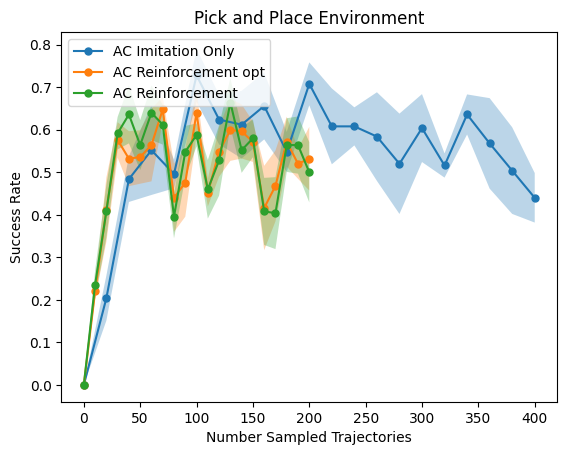

In [8]:
AC_path = '/data/bing/hendrik/AC_var_2023-03-17'
AC_path_21 = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_test_2023-02-21'

bl_rppo_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/rppo_02_26/'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL'

include_ac_pp_Im = ['pickplace opt mode: goal demonstrations: 20, im_ph:False, training_episodes: 20, min critic: 5e-05, wd: 0.01, val_every: 4000', 'stats']
exclude_ac_imitation = ['optimized']

include_ac_pp_Ref_20 = ['pickplace load opt actor opt mode: goal demonstrations: 20, im_ph:False, training_episodes: 20, min critic: 5e-05, wd: 0.01, val_every: 4000', 'statsoptimized']
exclude_ac_pp_Ref_20 = []

include_ac_pp_REF_opt = ['pickplace opt mode: goal demonstrations: 20, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 5000', 'statsoptimized']
exclude_ac_REF_opt  = []

include_ac_pp_REF = ['pickplace opt mode: goal demonstrations: 20, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 5000', 'stats']
exclude_ac_imitation_2 = ['optimized']

include_ppo_bl = ['demonstrations_14', 'PPO', 'learner', '0.0001']
exclude_ppo_bl = []
include_TQC_bl = ['demonstrations_14', 'learner', 'pickplace', 'TQC']
exclude_bl = []

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[AC_path, AC_path, AC_path], 
    includes=[include_ac_pp_Im, include_ac_pp_REF_opt, include_ac_pp_REF, include_ac_pp_Ref_20], 
    excludes=[exclude_ac_imitation, exclude_ac_REF_opt, exclude_ac_imitation_2, exclude_ac_pp_Ref_20],
    names=['AC Imitation Only', 'AC Reinforcement opt', 'AC Reinforcement', 'AC Reinforcement opt 20'],
    plot_name='Pick and Place Environment',
    save_path = None
    )

for path: /data/bing/hendrik/AC_var_2023-03-17: 5


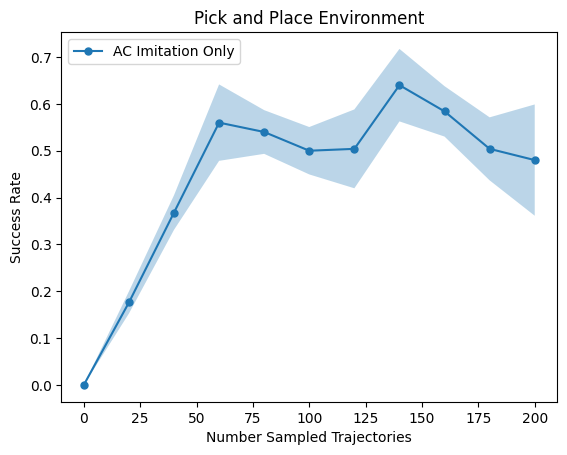

In [4]:
AC_path = '/data/bing/hendrik/AC_var_2023-03-17'
AC_path_21 = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_test_2023-02-21'

bl_rppo_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/rppo_02_26/'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL'

include_ac_pp_Im = ['pickplace opt mode: plan demonstrations: 20, im_ph:True, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 5000', 'statsoptimized']
exclude_ac_imitation = []

include_ac_pp_Ref_20 = ['pickplace load opt actor opt mode: goal demonstrations: 20, im_ph:False, training_episodes: 20, min critic: 5e-05, wd: 0.01, val_every: 4000', 'statsoptimized']
exclude_ac_pp_Ref_20 = []

include_ac_pp_REF_opt = ['pickplace', 'False', 'statsoptimized']
exclude_ac_REF_opt  = []

include_ac_pp_REF = ['pickplace', 'False', 'stats']
exclude_ac_imitation_2 = ['optimized']

include_ppo_bl = ['demonstrations_14', 'PPO', 'learner', '0.0001']
exclude_ppo_bl = []
include_TQC_bl = ['demonstrations_14', 'learner', 'pickplace', 'TQC']
exclude_bl = []

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[AC_path], 
    includes=[include_ac_pp_Ref_20], 
    excludes=[exclude_ac_pp_Ref_20],
    names=['AC Imitation Only', 'AC Reinforcement opt', 'AC Reinforcement', 'AC Reinforcement opt 20'],
    plot_name='Pick and Place Environment',
    save_path = None
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-02-23'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-02-22/'

include_ac = ['push', '10','True', 'stats', '2000']
exclude_ac = ['optimize']

include_bl = ['demonstrations_10', 'learner', 'push', 'PPO', '0.0001']
exclude_bl = []


save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[AC_path, bl_path], 
    includes=[include_ac, include_bl], 
    excludes=[exclude_ac, exclude_bl],
    names=['AC', 'PPO + GAIL'],
    plot_name='Push Environment',
    save_path = None
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-02-23'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-02-25/'

include_ac = ['push', '6','False', 'stats', '2000']
exclude_ac = ['optimize']

include_bl = ['demonstrations_6', 'learner', 'push', 'PPO', '3e-06']
exclude_bl = []


save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[AC_path, bl_path], 
    includes=[include_ac, include_bl], 
    excludes=[exclude_ac, exclude_bl],
    names=['AC', 'PPO + GAIL'],
    plot_name='Push Environment',
    save_path = None
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-02-23'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-02-22'


include_ac = ['push demonstrations: 20, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 5000', 'stats']
exclude_ac = ['optimize']

include_ac2 = ['push demonstrations: 20, im_ph:True, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 5000', 'stats']
exclude_ac2 = ['optimize']

include_bl = ['PPO_GAIL_push_lr_0.0001_demonstrations_20', 'learner']
exclude_bl = []

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[AC_path, AC_path, bl_path], 
    includes=[include_ac, include_ac2, include_bl], 
    excludes=[exclude_ac, exclude_ac, []],
    names=['AC Reinforcement', 'AC Imitation', 'PPO + GAIL'],
    plot_name='Push Environment',
    save_path = None
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-02-22_val_1000'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-02-22/'

include_ac = ['push', '20','True', 'stats']
exclude_ac = ['optimize']

include_bl = ['demonstrations_20', 'learner', 'push', 'PPO', '0.0001']
exclude_bl = []


save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[AC_path, bl_path], 
    includes=[include_ac, include_bl], 
    excludes=[exclude_ac, exclude_bl],
    names=['AC', 'PPO + GAIL'],
    plot_name='Push Environment',
    save_path = None
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_test_2023-02-21'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-02-21'

include_ac = ['pickplace demonstrations: 6, im_ph:False', 'stats']
exclude_ac = ['optimize']

include_bl14 = ['demonstrations_14', 'learner', 'push', 'PPO']
exclude_bl = []

include_bl10 = ['demonstrations_10', 'learner', 'push', 'PPO']
exclude_bl = []

include_bl6 = ['demonstrations_6', 'learner', 'push', 'TQC', 'id_0']
exclude_bl = []

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[bl_path, bl_path, bl_path], 
    includes=[include_bl14, include_bl10, include_bl6], 
    excludes=[exclude_bl, exclude_bl, exclude_bl],
    names=['14', '10', '6'],
    plot_name='Push Environment',
    save_path = save_path
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/pickplace 14/AC/'
PPOGail = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/pickplace 14/PPO GAIL'
TQCPath = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/pickplace 14/TQC GAIL'

include_ac = ['stats']
exclude_ac = ['optimize']

include_PPOGail = ['learner']
exclude_bl = []

include_TQC = ['learner']
exclude_bl = []

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/PickPlace_14/'

make_plot(
    paths=[AC_path, PPOGail, TQCPath], 
    includes=[include_ac, include_PPOGail, include_TQC], 
    excludes=[exclude_ac, exclude_bl, exclude_bl],
    names=['AC', 'PPO + GAIL', 'TQC + GAIL'],
    plot_name='Pick and Place Environment',
    save_path = save_path
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/pickplace 14/AC/'
PPOGail = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/pickplace 14/PPO GAIL'
TQCPath = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-09'

include_ac = ['stats']
exclude_ac = ['optimize']

include_PPOGail = ['learner']
exclude_bl = []

include_TQC = ['learner', 'RPPO']
exclude_bl = []

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/PickPlace_14/'

make_plot(
    paths=[AC_path, PPOGail, TQCPath], 
    includes=[include_ac, include_PPOGail, include_TQC], 
    excludes=[exclude_ac, exclude_bl, exclude_bl],
    names=['AC', 'PPO + GAIL', 'TQC + GAIL'],
    plot_name='Pick and Place Environment',
    save_path = save_path
    )

In [ ]:
AC_path = '/data/bing/hendrik/AC_var_2023-03-17'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-02-23'

include_ac_im = ['stats', 'window', '4', 'False']
exclude_ac = ['optimize']

include_ac_ref = ['statsoptimize', 'window', '4', 'False']
exclude_ac = []

include_PPO = ['learner_stats_gail', 'window', 'demonstrations_4', 'lr_0.0001', 'PPO']
exclude_PPO = []

include_TQC = ['learner_stats_gail', 'window', 'demonstrations_4', '1e-07', 'TQC']
exclude_TQC = []


save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/PickPlace_14/'

make_plot(
    paths=[AC_path,AC_path, bl_path, bl_path], 
    includes=[include_ac_im,include_ac_ref, include_PPO, include_TQC], 
    excludes=[exclude_ac,exclude_ac, exclude_PPO, exclude_PPO],
    names=['AC RE', 'AC RE optimize', 'PPO + GAIL', 'TQC + GAIL'],
    plot_name='Window Open Environment',
    save_path = None
    )